In [1]:
import numpy as np
import pandas as pd
import spacy

In [2]:
nlp = spacy.load("en")

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train['comment_text'] = train['comment_text'].astype(str)
test['comment_text'] = test['comment_text'].astype(str)

In [4]:
import numpy as np
from multiprocessing import cpu_count, Pool
  
def parallelize(data, func):
    cores = cpu_count()
    data_split = np.array_split(data, cores)
    pool = Pool(cores)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

In [7]:
def word_count(df):
    df = df.apply(lambda x: len(nlp(x)))
    return df

In [10]:
%%time
train['word_count'] = parallelize(train['comment_text'], word_count)

CPU times: user 3.86 s, sys: 3.14 s, total: 7 s
Wall time: 20min 26s


In [ ]:
%%time
test['word_count'] = parallelize(test['comment_text'], word_count)

In [14]:
from tqdm import tqdm as tqdm2

for text in tqdm2(train['comment_text']):
    nlp(text)

 11%|█         | 10430/95851 [04:08<33:55, 41.97it/s]

KeyboardInterrupt: 

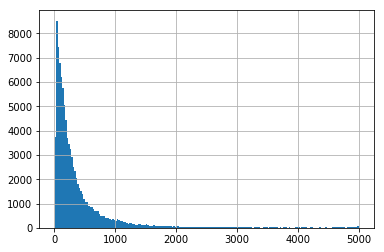

In [6]:
import matplotlib.pyplot as plt

train.comment_length.hist(bins=200)
plt.show()

In [22]:
train.to_csv("data/data_preprocess.csv")

In [24]:
train = pd.read_csv("data/data_preprocess.csv")

In [26]:
train.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_count
0,0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0,22
1,1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0,35
2,2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0,96
3,3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0,30
4,4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0,52


In [4]:
train['comment_length'] = train['comment_text'].apply(lambda x: len(x))

In [7]:
train['num_of_question_mark'] = train['comment_text'].apply(lambda x: x.count('?'))

In [8]:
train['num_of_exclaimation_mark'] = train['comment_text'].apply(lambda x: x.count('!'))

In [9]:
train['num_of_stars'] = train['comment_text'].apply(lambda x: x.count('*'))

In [11]:
train['num_of_capital'] = train['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))

In [4]:
def max_repeat_char_count(text):
    d={}
    for char in text:
        if char in d:
            d[char] = d[char] + 1
        else:
            d[char] = 1
            
    return max(d.values())

def preprocess(df):
    df['comment_text'] = df['comment_text'].astype(str)
    df['comment_length'] = df['comment_text'].apply(lambda x: len(x))
    df['word_count'] = df['comment_text'].apply(lambda x: len(x.split()))
    df['?_ratio'] = df['comment_text'].apply(lambda x: x.count('?')) / df['word_count']
    df['!_ratio'] = df['comment_text'].apply(lambda x: x.count('!')) / df['word_count']
    df['*_ratio'] = df['comment_text'].apply(lambda x: x.count('*')) / df['word_count']
    df['upper_ratio'] = df['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper())) / df['word_count']
    df['you_ratio'] = df['comment_text'].apply(lambda x: sum(1 for c in x.lower().split() if c == 'you' or c == 'your')) / df['word_count']
    df['continuous_char_ratio'] = df['comment_text'].apply(max_repeat_char_count) / df['word_count']
    return df

In [5]:
train = preprocess(train)
test = preprocess(test)

In [22]:
train.to_csv('data/train_manual_features_v2.csv')
test.to_csv('data/test_manual_features_v2.csv')

In [7]:
train['word_count'].describe()

count    95851.000000
mean        67.423605
std         99.806779
min          1.000000
25%         17.000000
50%         36.000000
75%         75.000000
max       1403.000000
Name: word_count, dtype: float64